<a href="https://colab.research.google.com/github/johnfriesen/tree_envelope_in_bavarian_cities/blob/main/merge_climate_envelope_bavarian_cities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code is costumized to be run on a Google Colaboratory in a Jupyter Notebook. Therefore, first the required packages have to be installed.

In [1]:
!pip install geopandas rasterstats contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 48.8 MB/s eta 0:00:00


In a first step the areas of interest are shown. We plot the mean temperature in Bavaria ("Temp_Bavaria.tif"), but other background images could be used. The boundaries of cities investigated were derived, using a shapefile from the German Census (https://www.zensus2022.de/DE/Presse/Grafik/shapefile.html). The list of ARS describe the biggest Bavarian cities. ARS is a unique identifier in the German Census.

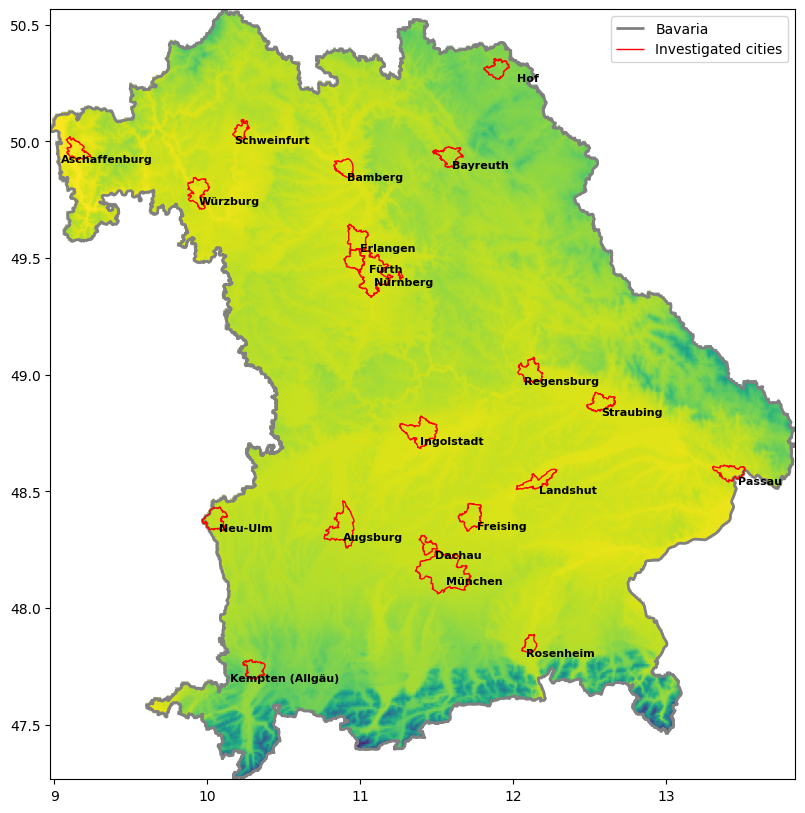

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

# 1. Shapefile laden und Spalte "ARS_0" als String formatieren
gdf = gpd.read_file("VG250_GEM.shp")
gdf['ARS_0'] = gdf['ARS_0'].astype(str)

# 2. Grenze von Bayern: Alle Features, deren ARS_0 mit "09" beginnen, zusammenführen (dissolve)
bayern = gdf[gdf['ARS_0'].str.startswith('09')].dissolve()

# 3. Filter für untersuchte Städte (wie in deinem ursprünglichen Code)
ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)].copy()

# 4. Lade den Hintergrund aus einer GeoTIFF-Datei.
#    Passe den Dateipfad nach Bedarf an.
with rasterio.open("Temp_Bavaria.tif") as src:
    # 5. Reprojektion der Geodaten in das CRS des GeoTIFF
    bayern_proj = bayern.to_crs(src.crs)
    gdf_filtered_proj = gdf_filtered.to_crs(src.crs)

    # 6. Plot erstellen
    fig, ax = plt.subplots(figsize=(10, 10))

    # Zeige das GeoTIFF als Hintergrund
    show(src, ax=ax)

    # Plot der bayerischen Umrandung
    bayern_proj.boundary.plot(ax=ax, edgecolor='grey', linewidth=2, label="Bavaria")

    # Plot der Umrandungen der untersuchten Städte
    gdf_filtered_proj.boundary.plot(ax=ax, edgecolor='red', linewidth=1, label="Investigated cities")

    # Füge die Stadtnamen in Weiß hinzu (angenommen, der Name steht in der Spalte "GEN")
    for idx, row in gdf_filtered_proj.iterrows():
      centroid = row.geometry.centroid
      # Define your offsets (adjust these values as needed)
      offset_x = 0.2
      offset_y = -0.04
      ax.text(centroid.x + offset_x, centroid.y + offset_y, row["GEN"],
            fontsize=8, color='black', ha='center', va='center', fontweight='bold')

    #ax.set_title("Karte: GeoTIFF Hintergrund, Bayern und untersuchte Städte")
    ax.legend()
    plt.show()



In a next step, the Climate envelopes (.tif) (available upon request from the authors), and the boundaries of the cities have to be loaded. An examplary climate envolpe is plotted below.

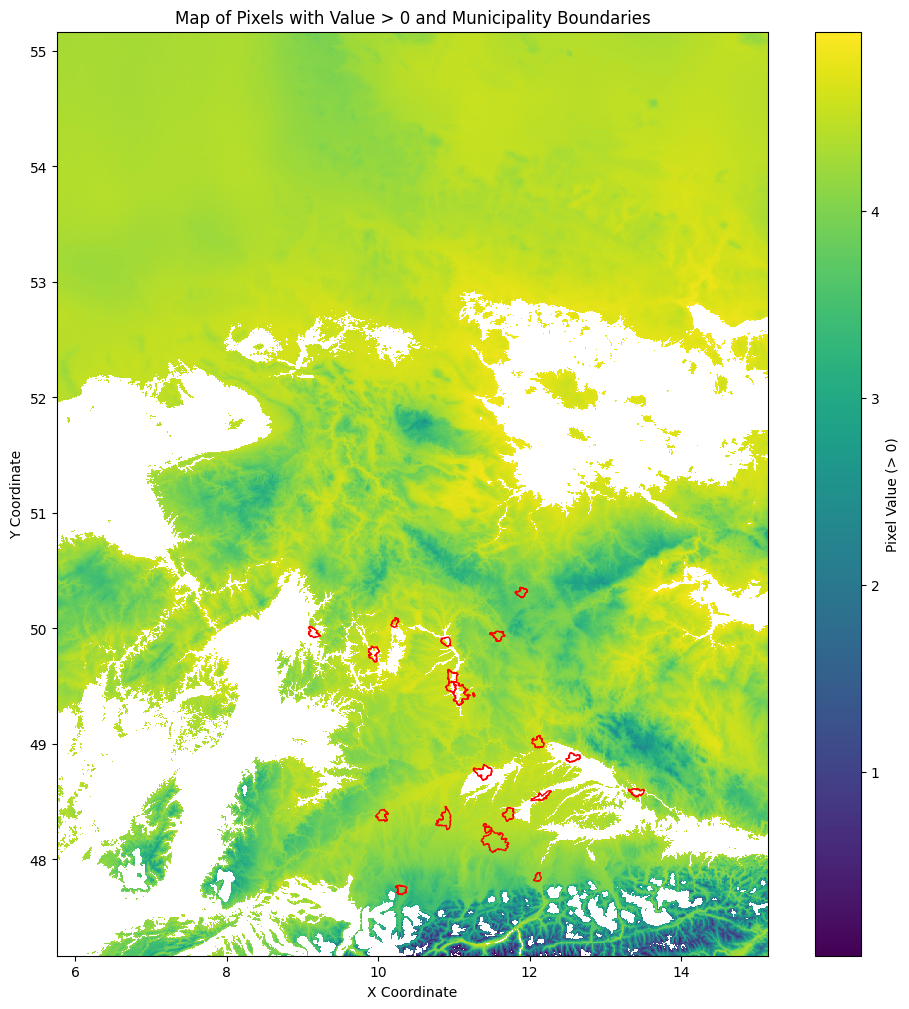

In [2]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
import numpy as np

# Define file paths
raster_path = "Rotbuche_2071-2100.tif"
shapefile_path = "VG250_GEM.shp"

# Load the raster and read channel one
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # first band
    transform = src.transform
    # Create a version of the raster that only keeps pixels > 0, others set to nan
    raster_valid = np.where(raster_data > 0, raster_data, np.nan)
    bounds = src.bounds  # used for plotting the raster correctly

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Define your list of ARS codes
ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)]

# Reproject the shapefile to the raster's CRS if needed
if gdf_filtered.crs != src.crs:
    gdf_filtered = gdf_filtered.to_crs(src.crs)

# Plot the raster and municipality boundaries
fig, ax = plt.subplots(figsize=(12, 12))
# Plot the raster with extent defined by the raster bounds (to correctly position pixels)
im = ax.imshow(raster_valid,
               extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
               cmap='viridis',
               interpolation='none')
# Overlay municipality boundaries
gdf_filtered.boundary.plot(ax=ax, edgecolor='red', linewidth=1)

# Add a colorbar for the raster
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Pixel Value (> 0)')

ax.set_title('Map of Pixels with Value > 0 and Municipality Boundaries')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.show()


In the following code, an examplary municipality is plotted.

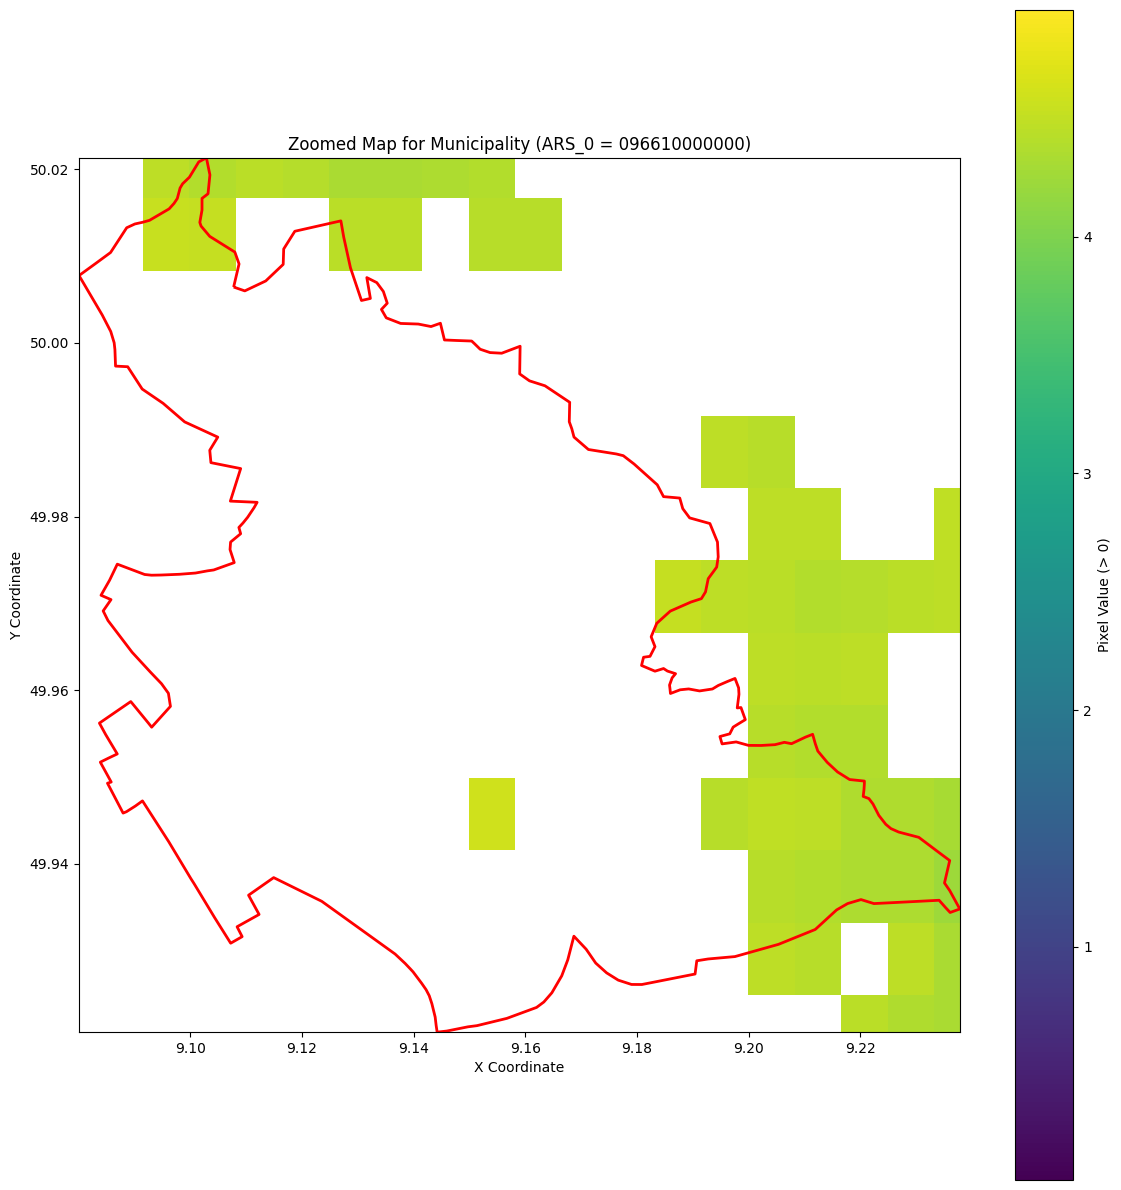

In [11]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
import numpy as np

# Define file paths
raster_path = "Rotbuche_2071-2100.tif"
shapefile_path = "VG250_GEM.shp"

# Load the raster and read channel one
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # first band
    transform = src.transform
    # Create a version of the raster that only keeps pixels > 0, others set to nan
    raster_valid = np.where(raster_data > 0, raster_data, np.nan)
    bounds = src.bounds  # used for plotting the raster correctly

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Define your list of ARS codes
ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)]

# Reproject the shapefile to the raster's CRS if needed
with rasterio.open(raster_path) as src:
    if gdf_filtered.crs != src.crs:
        gdf_filtered = gdf_filtered.to_crs(src.crs)

# Select only one municipality (e.g., the first one)
single_muni = gdf_filtered.iloc[[15]]

# Get the bounding box of the selected municipality to zoom in
xmin, ymin, xmax, ymax = single_muni.total_bounds

# Plot the raster and the selected municipality boundary
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(raster_valid,
               extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
               cmap='viridis',
               interpolation='none')

# Overlay only the boundary of the chosen municipality
single_muni.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

# Zoom to the bounding box of the selected municipality
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Add a colorbar and labels
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Pixel Value (> 0)')

ax.set_title(f"Zoomed Map for Municipality (ARS_0 = {single_muni.iloc[0]['ARS_0']})")
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.tight_layout()
plt.show()



Calculate the share of area within the climate envelopes for every city and every tree species and store all results in a .csv.

In [14]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# -----------------------------------------------------------------
# 1. Set up the mapping of (species, time_frame) to raster file paths
# -----------------------------------------------------------------
raster_files = {
    ('Rotbuche', '2011-2040'): "Rotbuche_2011-2040.tif",
    ('Rotbuche', '2041-2070'): "Rotbuche_2041-2070.tif",
    ('Rotbuche', '2071-2100'): "Rotbuche_2071-2100.tif",
    ('Spitzahorn', '2011-2040'): "Spitzahorn_2011-2040.tif",
    ('Spitzahorn', '2041-2070'): "Spitzahorn_2041-2070.tif",
    ('Spitzahorn', '2071-2100'): "Spitzahorn_2071-2100.tif",
    ('Bergahorn', '2011-2040'): "Bergahorn_2011-2040.tif",
    ('Bergahorn', '2041-2070'): "Bergahorn_2041-2070.tif",
    ('Bergahorn', '2071-2100'): "Bergahorn_2071-2100.tif",
    ('Stieleiche', '2011-2040'): "Stieleiche_2011-2040.tif",
    ('Stieleiche', '2041-2070'): "Stieleiche_2041-2070.tif",
    ('Stieleiche', '2071-2100'): "Stieleiche_2071-2100.tif",
    ('Winterlinde', '2011-2040'): "Winterlinde_2011-2040.tif",
    ('Winterlinde', '2041-2070'): "Winterlinde_2041-2070.tif",
    ('Winterlinde', '2071-2100'): "Winterlinde_2071-2100.tif",
    ('Haengebirke/Sandbirke', '2011-2040'): "Haengebirke_Sandbirke_2011-2040.tif",
    ('Haengebirke/Sandbirke', '2041-2070'): "Haengebirke_Sandbirke_2041-2070.tif",
    ('Haengebirke/Sandbirke', '2071-2100'): "Haengebirke_Sandbirke_2071-2100.tif",
    ('Schwarzpappel', '2011-2040'): "Schwarz_pappel_2011-2040.tif",
    ('Schwarzpappel', '2041-2070'): "Schwarz_pappel_2041-2070.tif",
    ('Schwarzpappel', '2071-2100'): "Schwarz_pappel_2071-2100.tif",
    ('Hainbuche', '2011-2040'): "Hainbuche_2011-2040.tif",
    ('Hainbuche', '2041-2070'): "Hainbuche_2041-2070.tif",
    ('Hainbuche', '2071-2100'): "Hainbuche_2071-2100.tif",
    ('Gemeine Esche', '2011-2040'): "Gemeine_Esche_2011-2040.tif",
    ('Gemeine Esche', '2041-2070'): "Gemeine_Esche_2041-2070.tif",
    ('Gemeine Esche', '2071-2100'): "Gemeine_Esche_2071-2100.tif",
    ('Londoner Platane', '2011-2040'): "nh2011_Londoner_Platane.tif",
    ('Londoner Platane', '2041-2070'): "nh2041_Londoner_Platane.tif",
    ('Londoner Platane', '2071-2100'): "nh2071_Londoner_Platane.tif",
    ('Gemeine Robinie', '2011-2040'): "Gemeine_Robinie_2011-2040.tif",
    ('Gemeine Robinie', '2041-2070'): "Gemeine_Robinie_2041-2070.tif",
    ('Gemeine Robinie', '2071-2100'): "Gemeine_Robinie_2071-2100.tif",
    ('Gewöhnliche Rosskastanie', '2011-2040'): "nh2011_Gewoehnliche_Rosskastanie.tif",
    ('Gewöhnliche Rosskastanie', '2041-2070'): "nh2041_Gewoehnliche_Rosskastanie.tif",
    ('Gewöhnliche Rosskastanie', '2071-2100'): "nh2071_Gewoehnliche_Rosskastanie.tif"
}

# -----------------------------------------------------------------
# 2. Load the shapefile and filter by your ARS list (if needed)
#    We'll use the "GEN" column for city names.
# -----------------------------------------------------------------
shapefile_path = "VG250_GEM.shp"
gdf = gpd.read_file(shapefile_path)

ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)].copy()

# -----------------------------------------------------------------
# 3. Define a function to compute pixel metrics for a given polygon and raster.
# -----------------------------------------------------------------
def get_polygon_metrics(raster_path, polygon):
    with rasterio.open(raster_path) as src:
        # Extract the raster values over the polygon's bounding box.
        out_image, out_transform = mask(src, [polygon.__geo_interface__],
                                        crop=True, all_touched=True, filled=True)
        data_filled = out_image[0]  # first band

        # Create a geometry mask based solely on the polygon.
        poly_mask = geometry_mask([polygon.__geo_interface__],
                                  out_shape=data_filled.shape,
                                  transform=out_transform,
                                  invert=True)
        # Count total pixels inside the polygon (using the geometry mask)
        total_pixels = np.sum(poly_mask)
        # Count valid pixels (inside the polygon with value > 0)
        valid_pixels = np.sum((data_filled > 0) & poly_mask)
        pct_valid = (valid_pixels / total_pixels * 100) if total_pixels > 0 else 0

    return int(total_pixels), int(valid_pixels), pct_valid

# -----------------------------------------------------------------
# 4. Reproject the shapefile to the CRS of the rasters.
#    Here, we assume all rasters share the same CRS.
# -----------------------------------------------------------------
# Get the CRS from one of the rasters:
first_raster = list(raster_files.values())[0]
with rasterio.open(first_raster) as src:
    raster_crs = src.crs

if gdf_filtered.crs != raster_crs:
    gdf_filtered = gdf_filtered.to_crs(raster_crs)

# -----------------------------------------------------------------
# 5. Loop over each city (using the "GEN" column for names)
#    and each raster (species and time_frame) to compute metrics.
# -----------------------------------------------------------------
results = []
for idx, row in gdf_filtered.iterrows():
    city_name = row["GEN"]
    polygon = row.geometry
    for (species, time_frame), raster_file in raster_files.items():
        total_pixels, valid_pixels, pct_valid = get_polygon_metrics(raster_file, polygon)
        results.append({
            "City": city_name,
            "Species": species,
            "Time_Frame": time_frame,
            "TOTAL_PIXELS": total_pixels,
            "VALID_PIXELS": valid_pixels,
            "PCT_VALID": pct_valid
        })

df_results = pd.DataFrame(results)
#print(df_results)
df_results.to_csv('results.csv', index=False)





Create climate envelopes for every city, every timespan and every tree species and store them in a seperate folder.

In [13]:
import os
import zipfile
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.errors import RasterioError
import numpy as np

# -----------------------------------------------------------------
# 1. Mapping of German species names to English.
# -----------------------------------------------------------------
species_mapping = {
    "Rotbuche": "European Beech",
    "Spitzahorn": "Norway Maple",
    "Bergahorn": "Sycamore Maple",
    "Gemeine Robinie": "Black Locust",
    "Gewöhnliche Rosskastanie": "Horse Chestnut",
    "Haengebirke/Sandbirke": "Silver Birch",
    "Hainbuche": "European Hornbeam",
    "Londoner Platane": "London Plane",
    "Schwarzpappel": "Black Poplar",
    "Stieleiche": "Pedunculate Oak",
    "Winterlinde": "Small-Leaved Lime",
    "Gemeine Esche": "Common Ash"
}

# -----------------------------------------------------------------
# 2. Mapping of (species, time_frame) to raster file paths.
# -----------------------------------------------------------------
raster_files = {
    ('Rotbuche', '2011-2040'): "Rotbuche_2011-2040.tif",
    ('Rotbuche', '2041-2070'): "Rotbuche_2041-2070.tif",
    ('Rotbuche', '2071-2100'): "Rotbuche_2071-2100.tif",
    ('Spitzahorn', '2011-2040'): "Spitzahorn_2011-2040.tif",
    ('Spitzahorn', '2041-2070'): "Spitzahorn_2041-2070.tif",
    ('Spitzahorn', '2071-2100'): "Spitzahorn_2071-2100.tif",
    ('Bergahorn', '2011-2040'): "Bergahorn_2011-2040.tif",
    ('Bergahorn', '2041-2070'): "Bergahorn_2041-2070.tif",
    ('Bergahorn', '2071-2100'): "Bergahorn_2071-2100.tif",
    ('Stieleiche', '2011-2040'): "Stieleiche_2011-2040.tif",
    ('Stieleiche', '2041-2070'): "Stieleiche_2041-2070.tif",
    ('Stieleiche', '2071-2100'): "Stieleiche_2071-2100.tif",
    ('Winterlinde', '2011-2040'): "Winterlinde_2011-2040.tif",
    ('Winterlinde', '2041-2070'): "Winterlinde_2041-2070.tif",
    ('Winterlinde', '2071-2100'): "Winterlinde_2071-2100.tif",
    ('Haengebirke/Sandbirke', '2011-2040'): "Haengebirke_Sandbirke_2011-2040.tif",
    ('Haengebirke/Sandbirke', '2041-2070'): "Haengebirke_Sandbirke_2041-2070.tif",
    ('Haengebirke/Sandbirke', '2071-2100'): "Haengebirke_Sandbirke_2071-2100.tif",
    ('Schwarzpappel', '2011-2040'): "Schwarz_pappel_2011-2040.tif",
    ('Schwarzpappel', '2041-2070'): "Schwarz_pappel_2041-2070.tif",
    ('Schwarzpappel', '2071-2100'): "Schwarz_pappel_2071-2100.tif",
    ('Hainbuche', '2011-2040'): "Hainbuche_2011-2040.tif",
    ('Hainbuche', '2041-2070'): "Hainbuche_2041-2070.tif",
    ('Hainbuche', '2071-2100'): "Hainbuche_2071-2100.tif",
    ('Gemeine Esche', '2011-2040'): "Gemeine_Esche_2011-2040.tif",
    ('Gemeine Esche', '2041-2070'): "Gemeine_Esche_2041-2070.tif",
    ('Gemeine Esche', '2071-2100'): "Gemeine_Esche_2071-2100.tif",
    ('Londoner Platane', '2011-2040'): "nh2011_Londoner_Platane.tif",
    ('Londoner Platane', '2041-2070'): "nh2041_Londoner_Platane.tif",
    ('Londoner Platane', '2071-2100'): "nh2071_Londoner_Platane.tif",
    ('Gemeine Robinie', '2011-2040'): "Gemeine_Robinie_2011-2040.tif",
    ('Gemeine Robinie', '2041-2070'): "Gemeine_Robinie_2041-2070.tif",
    ('Gemeine Robinie', '2071-2100'): "Gemeine_Robinie_2071-2100.tif",
    ('Gewöhnliche Rosskastanie', '2011-2040'): "nh2011_Gewoehnliche_Rosskastanie.tif",
    ('Gewöhnliche Rosskastanie', '2041-2070'): "nh2041_Gewoehnliche_Rosskastanie.tif",
    ('Gewöhnliche Rosskastanie', '2071-2100'): "nh2071_Gewoehnliche_Rosskastanie.tif"
}

# -----------------------------------------------------------------
# 3. Load the shapefile and filter cities by ARS codes (using "GEN" column for names).
# -----------------------------------------------------------------
shapefile_path = "VG250_GEM.shp"
gdf = gpd.read_file(shapefile_path)

ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092610000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)].copy()

# -----------------------------------------------------------------
# 4. Function to clip the raster with a polygon and write a GeoTIFF.
#    Also adds the English species name to the metadata.
# -----------------------------------------------------------------
def create_clipped_geotiff(raster_path, polygon, out_path, english_species):
    try:
        with rasterio.open(raster_path) as src:
            out_image, out_transform = mask(src, [polygon.__geo_interface__],
                                            crop=True, all_touched=True, filled=True)
            out_meta = src.meta.copy()
            # Update metadata for new dimensions, transform, and CRS.
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })
    except RasterioError as e:
        print(f"Error with raster {raster_path}: {e}")
        return False

    # Write the clipped raster to a new file.
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(out_image)
        # Update file tags with the English species name.
        dest.update_tags(ENGLISH_SPECIES=english_species)
    return True

# -----------------------------------------------------------------
# 5. Prepare the output folder.
# -----------------------------------------------------------------
output_folder = "output_geotiffs"
os.makedirs(output_folder, exist_ok=True)

# -----------------------------------------------------------------
# 6. Reproject the shapefile to match the CRS of the rasters (assumed same for all).
# -----------------------------------------------------------------
first_raster = list(raster_files.values())[0]
with rasterio.open(first_raster) as src:
    raster_crs = src.crs

if gdf_filtered.crs != raster_crs:
    gdf_filtered = gdf_filtered.to_crs(raster_crs)

# -----------------------------------------------------------------
# 7. Loop over each city and each (species, time_frame) to create GeoTIFFs.
# -----------------------------------------------------------------
n_created = 0
for idx, city_row in gdf_filtered.iterrows():
    city_name = city_row["GEN"].replace(" ", "_")
    polygon = city_row.geometry
    for (species, time_frame), raster_file in raster_files.items():
        # Get the English species name for output filenames.
        english_species = species_mapping.get(species, species)
        # Use the English species name in the filename (sanitized).
        species_filename = english_species.replace(" ", "_").replace("/", "_")
        out_filename = f"{city_name}_{species_filename}_{time_frame}.tif"
        out_path = os.path.join(output_folder, out_filename)
        success = create_clipped_geotiff(raster_file, polygon, out_path, english_species)
        if success:
            n_created += 1

print(f"Created {n_created} GeoTIFF files.")

# -----------------------------------------------------------------
# 8. ZIP the output folder.
# -----------------------------------------------------------------
zip_filename = "output_geotiffs.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_folder):
        for file in files:
            file_path = os.path.join(root, file)
            rel_path = os.path.relpath(file_path, output_folder)
            zipf.write(file_path, arcname=rel_path)

print(f"Created ZIP archive: {zip_filename}")


Created 720 GeoTIFF files.
Created ZIP archive: output_geotiffs.zip


Create plots to analyse the climate envelopes for different tree species in cities.

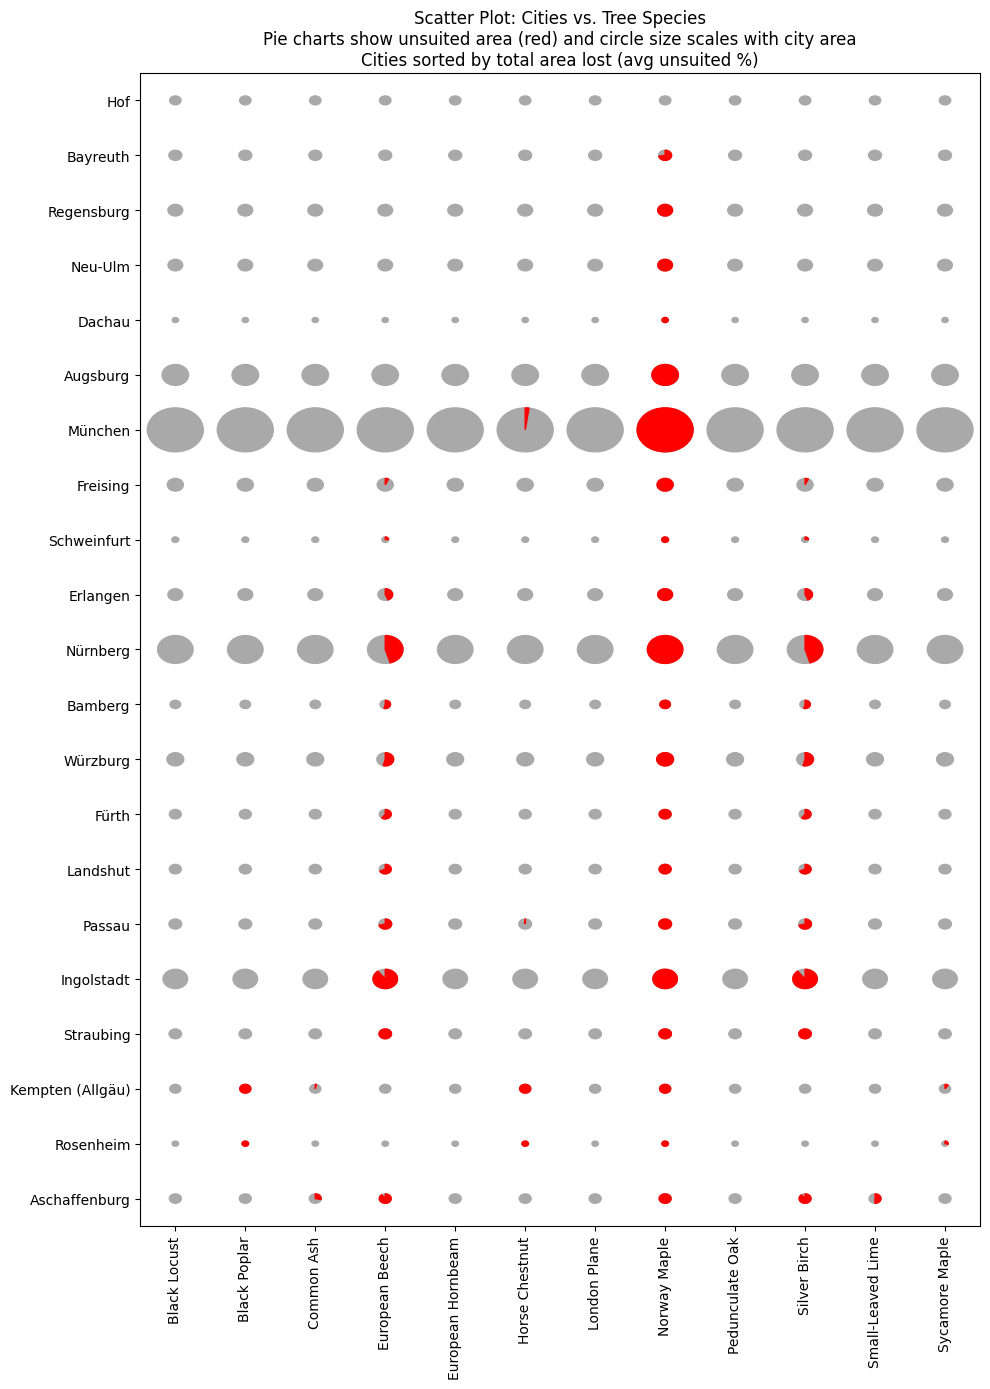

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle

df_results = pd.read_csv('results.csv')

species_mapping = {
    "Rotbuche": "European Beech",
    "Spitzahorn": "Norway Maple",
    "Bergahorn": "Sycamore Maple",
    "Gemeine Robinie": "Black Locust",
    "Gewöhnliche Rosskastanie": "Horse Chestnut",
    "Haengebirke/Sandbirke": "Silver Birch",
    "Hainbuche": "European Hornbeam",
    "Londoner Platane": "London Plane",
    "Schwarzpappel": "Black Poplar",
    "Stieleiche": "Pedunculate Oak",
    "Winterlinde": "Small-Leaved Lime",
    "Gemeine Esche": "Common Ash"
    # Add any additional mappings as needed.
}
df_results["Species"] = df_results["Species"].replace(species_mapping)
# ---------------------------
# 1. Data Preparation
# ---------------------------
# df_results contains the results from your earlier workflow.
# First, for each combination of City and Tree Species, we determine the minimal PCT_VALID over all time frames.
df_min = df_results.groupby(["City", "Species"])["PCT_VALID"].min().reset_index()

# Calculate the percentage of unsuited area (i.e. area lost) per cell.
df_min["Unsuitable"] = 100 - df_min["PCT_VALID"]

# Create a pivot table: rows = Cities, columns = Tree Species, values = Unsuitable (0 to 100)
pivot_unsuitable = df_min.pivot(index="City", columns="Species", values="Unsuitable")

# ---------------------------
# 2. Sorting Cities by Total Area Lost
# ---------------------------
# For each city, compute the average unsuited percentage (ignoring missing values).
city_loss = pivot_unsuitable.mean(axis=1)
# Sort cities by the average unsuited percentage in descending order
sorted_cities = city_loss.sort_values(ascending=False).index.tolist()

# Reorder the pivot table rows according to sorted cities.
pivot_unsuitable = pivot_unsuitable.loc[sorted_cities]
cities = pivot_unsuitable.index.tolist()
species = pivot_unsuitable.columns.tolist()

# ---------------------------
# 3. Retrieve City Areas for Scaling the Circle Size
# ---------------------------
# Load the shapefile ("VG250_GEM.shp")
gdf = gpd.read_file("VG250_GEM.shp")
gdf["ARS_0"] = gdf["ARS_0"].astype(str)

# Filter for the investigated cities (as in your previous code)
ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf["ARS_0"].isin(ars_list)].copy()

# To obtain valid area measurements, reproject to a metric CRS (EPSG:3857)
gdf_filtered_metric = gdf_filtered.to_crs(epsg=3857)
gdf_filtered_metric["area"] = gdf_filtered_metric["geometry"].area

# Create a dictionary mapping City name (assumed to be in the "GEN" column) to city area.
city_area = dict(zip(gdf_filtered_metric["GEN"], gdf_filtered_metric["area"]))

# Determine the maximum area for scaling purposes.
max_area = max(city_area.values())

# Define the maximum circle diameter (in plot coordinate units), e.g. 0.8.
max_diam = 0.8

# ---------------------------
# 4. Scatter Plot with Pie Chart Circles
# ---------------------------
fig, ax = plt.subplots(figsize=(10, 14))

# For each cell (combination City, Tree Species), draw a circle whose diameter scales with the city area,
# and inside the circle, plot a pie chart that shows the unsuited area percentage.
for i, city in enumerate(cities):
    for j, sp in enumerate(species):
        # Skip cells without data
        if pd.isna(pivot_unsuitable.loc[city, sp]):
            continue

        # Unsuited percentage (0 to 100)
        unsuited = pivot_unsuitable.loc[city, sp]
        # Fraction unsuited (between 0 and 1)
        f = unsuited / 100.0

        # Determine circle diameter based on the city area (linearly scaled)
        area_val = city_area.get(city, 0)
        diam = (area_val / max_area) * max_diam
        radius = diam / 2.0

        # Determine the position: x = index of tree species, y = index of city.
        x = j
        y = i

        # Draw the full circle in dark grey (representing the suitable area).
        base_circle = Circle((x, y), radius=radius, color='darkgrey', zorder=1)
        ax.add_patch(base_circle)

        # If the unsuited fraction is greater than 0, draw a red wedge (pie slice) showing the unsuited area.
        if f > 0:
            # Starting at 90° (top) and moving clockwise.
            # Matplotlib's Wedge draws counter-clockwise by default so we adjust the angles:
            wedge = Wedge((x, y), radius, theta1=90 - 360*f, theta2=90, color='red', zorder=2)
            ax.add_patch(wedge)

# ---------------------------
# 5. Axes and Labels
# ---------------------------
# Set axis limits so that all cells are visible.
ax.set_xlim(-0.5, len(species)-0.5)
ax.set_ylim(-0.5, len(cities)-0.5)

# Set ticks and labels for tree species (x-axis) and cities (y-axis)
ax.set_xticks(np.arange(len(species)))
ax.set_xticklabels(species, rotation=90)
ax.set_yticks(np.arange(len(cities)))
ax.set_yticklabels(cities)

ax.set_title("Scatter Plot: Cities vs. Tree Species\nPie charts show unsuited area (red) and circle size scales with city area\nCities sorted by total area lost (avg unsuited %)")
plt.tight_layout()
plt.show()


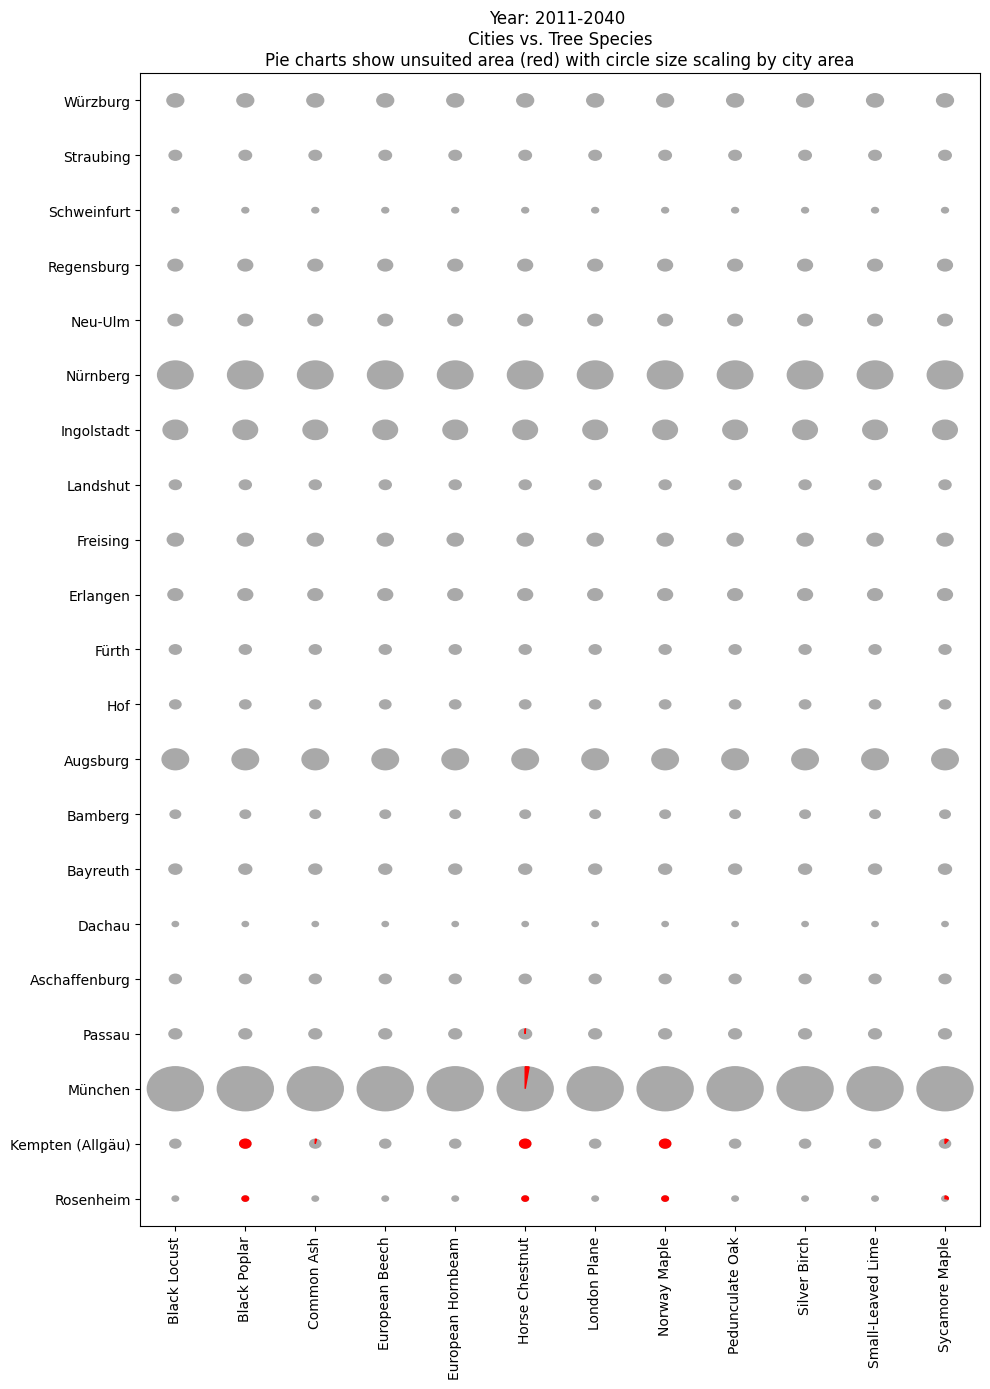

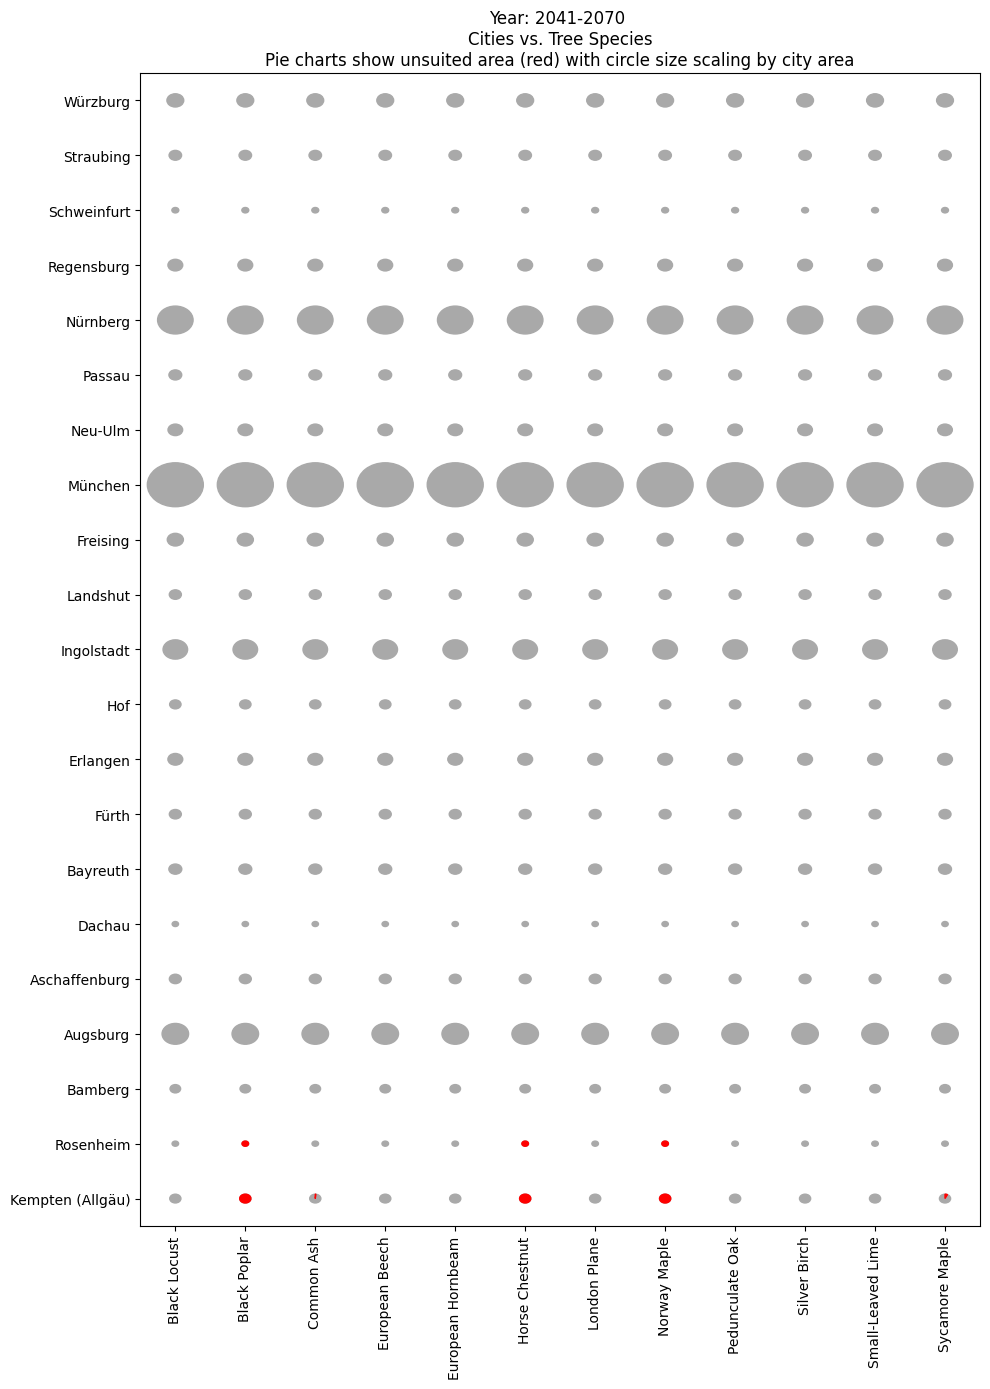

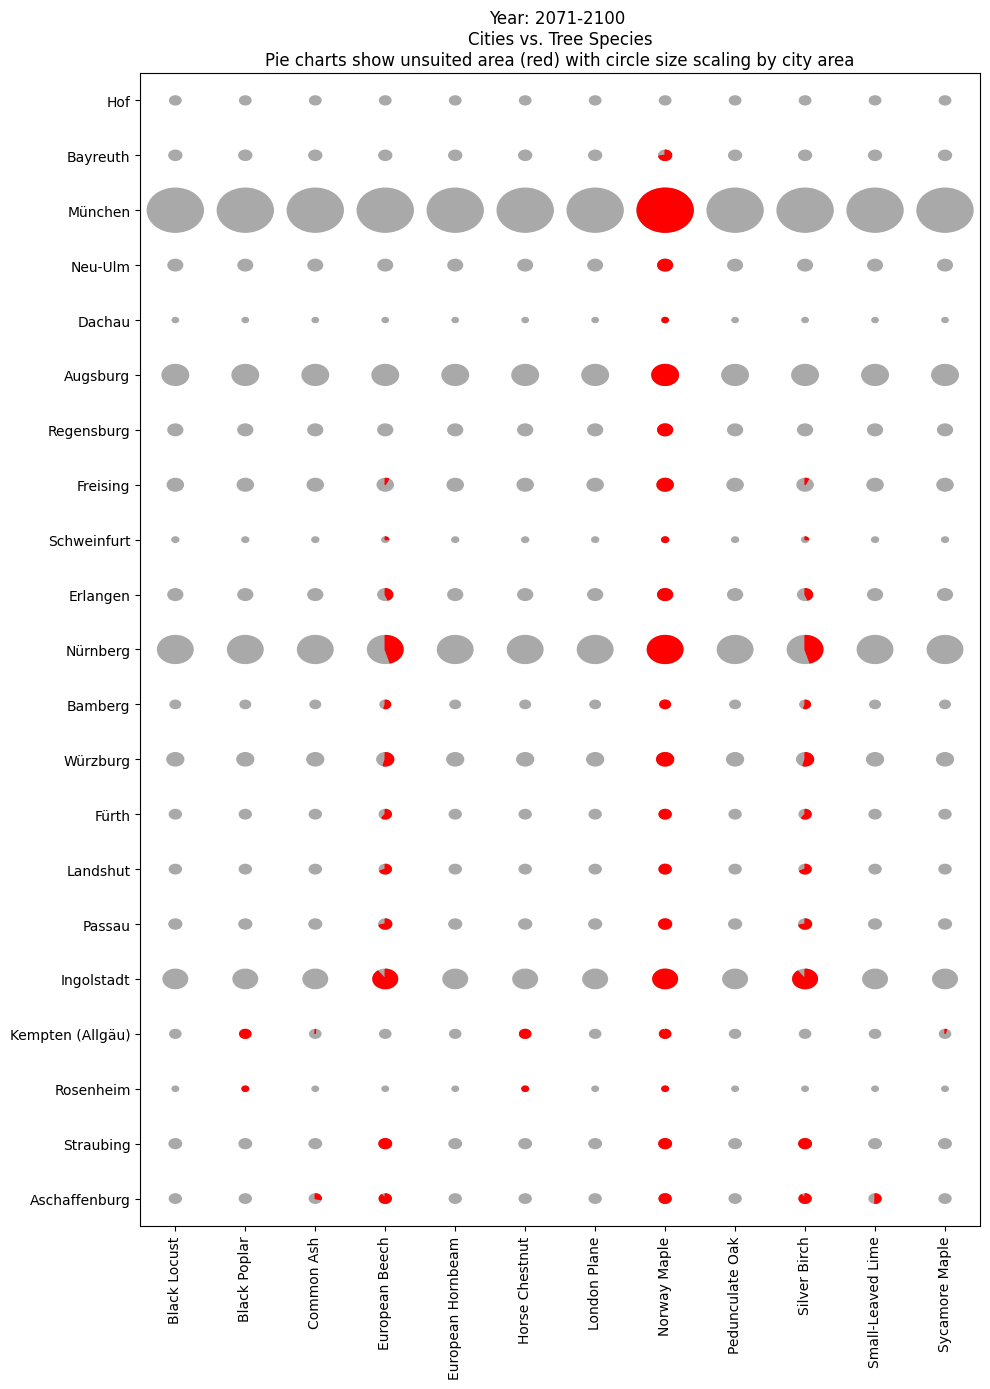

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle

# ---------------------------
# 0. Load and Preprocess the CSV Data
# ---------------------------
df_results = pd.read_csv('results.csv')

# Map species names from German to English
species_mapping = {
    "Rotbuche": "European Beech",
    "Spitzahorn": "Norway Maple",
    "Bergahorn": "Sycamore Maple",
    "Gemeine Robinie": "Black Locust",
    "Gewöhnliche Rosskastanie": "Horse Chestnut",
    "Haengebirke/Sandbirke": "Silver Birch",
    "Hainbuche": "European Hornbeam",
    "Londoner Platane": "London Plane",
    "Schwarzpappel": "Black Poplar",
    "Stieleiche": "Pedunculate Oak",
    "Winterlinde": "Small-Leaved Lime",
    "Gemeine Esche": "Common Ash"
    # Add any additional mappings as needed.
}
df_results["Species"] = df_results["Species"].replace(species_mapping)

# ---------------------------
# 1. Retrieve City Areas for Scaling the Circle Size
# ---------------------------
# Load the shapefile ("VG250_GEM.shp") and process city areas.
gdf = gpd.read_file("VG250_GEM.shp")
gdf["ARS_0"] = gdf["ARS_0"].astype(str)

ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf["ARS_0"].isin(ars_list)].copy()

# Reproject to a metric CRS (here EPSG:3857) for area calculations
gdf_filtered_metric = gdf_filtered.to_crs(epsg=3857)
gdf_filtered_metric["area"] = gdf_filtered_metric["geometry"].area

# Assume the city name is stored in the "GEN" column
city_area = dict(zip(gdf_filtered_metric["GEN"], gdf_filtered_metric["area"]))
max_area = max(city_area.values())
max_diam = 0.8  # Maximum circle diameter (in plot units)

# ---------------------------
# 2. Loop Over Each Time Step (Year) and Create a Plot
# ---------------------------
# The following code assumes that your CSV has a column named "Year".
# If your column is named differently, replace "Year" with the appropriate name.
unique_years = sorted(df_results['Time_Frame'].unique())

for year in unique_years:
    # Filter data for the current time step
    df_year = df_results[df_results["Time_Frame"] == year].copy()

    # For each combination of City and Species, take the minimal PCT_VALID value in that time step.
    df_min = df_year.groupby(["City", "Species"])["PCT_VALID"].min().reset_index()

    # Compute unsuited percentage (area lost) per cell.
    df_min["Unsuitable"] = 100 - df_min["PCT_VALID"]

    # Create pivot table (rows = Cities, columns = Tree Species, values = Unsuitable)
    pivot_unsuitable = df_min.pivot(index="City", columns="Species", values="Unsuitable")

    # Sort the cities by the average unsuited percentage (this order may change over time)
    city_loss = pivot_unsuitable.mean(axis=1)
    sorted_cities = city_loss.sort_values(ascending=False).index.tolist()
    pivot_unsuitable = pivot_unsuitable.loc[sorted_cities]
    cities = pivot_unsuitable.index.tolist()
    species = pivot_unsuitable.columns.tolist()

    # ---------------------------
    # 3. Create the Scatter Plot with Pie Chart Circles for this Year
    # ---------------------------
    fig, ax = plt.subplots(figsize=(10, 14))

    # Draw one circle for each combination of city and tree species
    for i, city in enumerate(cities):
        for j, sp in enumerate(species):
            # Skip if there is no data for this cell.
            if pd.isna(pivot_unsuitable.loc[city, sp]):
                continue

            # Unsuited percentage (0 to 100)
            unsuited = pivot_unsuitable.loc[city, sp]
            # Fraction unsuited (between 0 and 1)
            f = unsuited / 100.0

            # Determine circle diameter based on the city area (linearly scaled)
            area_val = city_area.get(city, 0)
            diam = (area_val / max_area) * max_diam
            radius = diam / 2.0

            # X = index of tree species; Y = index of city.
            x = j
            y = i

            # Draw the full circle in dark grey representing the suitable area.
            base_circle = Circle((x, y), radius=radius, color='darkgrey', zorder=1)
            ax.add_patch(base_circle)

            # If there is an unsuited fraction, overlay a red wedge (pie slice)
            if f > 0:
                # Wedge is drawn starting at 90° (top) moving clockwise.
                wedge = Wedge((x, y), radius, theta1=90 - 360*f, theta2=90, color='red', zorder=2)
                ax.add_patch(wedge)

    # Set axis limits so that all cells are visible.
    ax.set_xlim(-0.5, len(species) - 0.5)
    ax.set_ylim(-0.5, len(cities) - 0.5)

    # Set tick labels for tree species (x-axis) and cities (y-axis)
    ax.set_xticks(np.arange(len(species)))
    ax.set_xticklabels(species, rotation=90)
    ax.set_yticks(np.arange(len(cities)))
    ax.set_yticklabels(cities)

    ax.set_title(f"Year: {year} \nCities vs. Tree Species\nPie charts show unsuited area (red) with circle size scaling by city area")
    plt.tight_layout()
    plt.show()


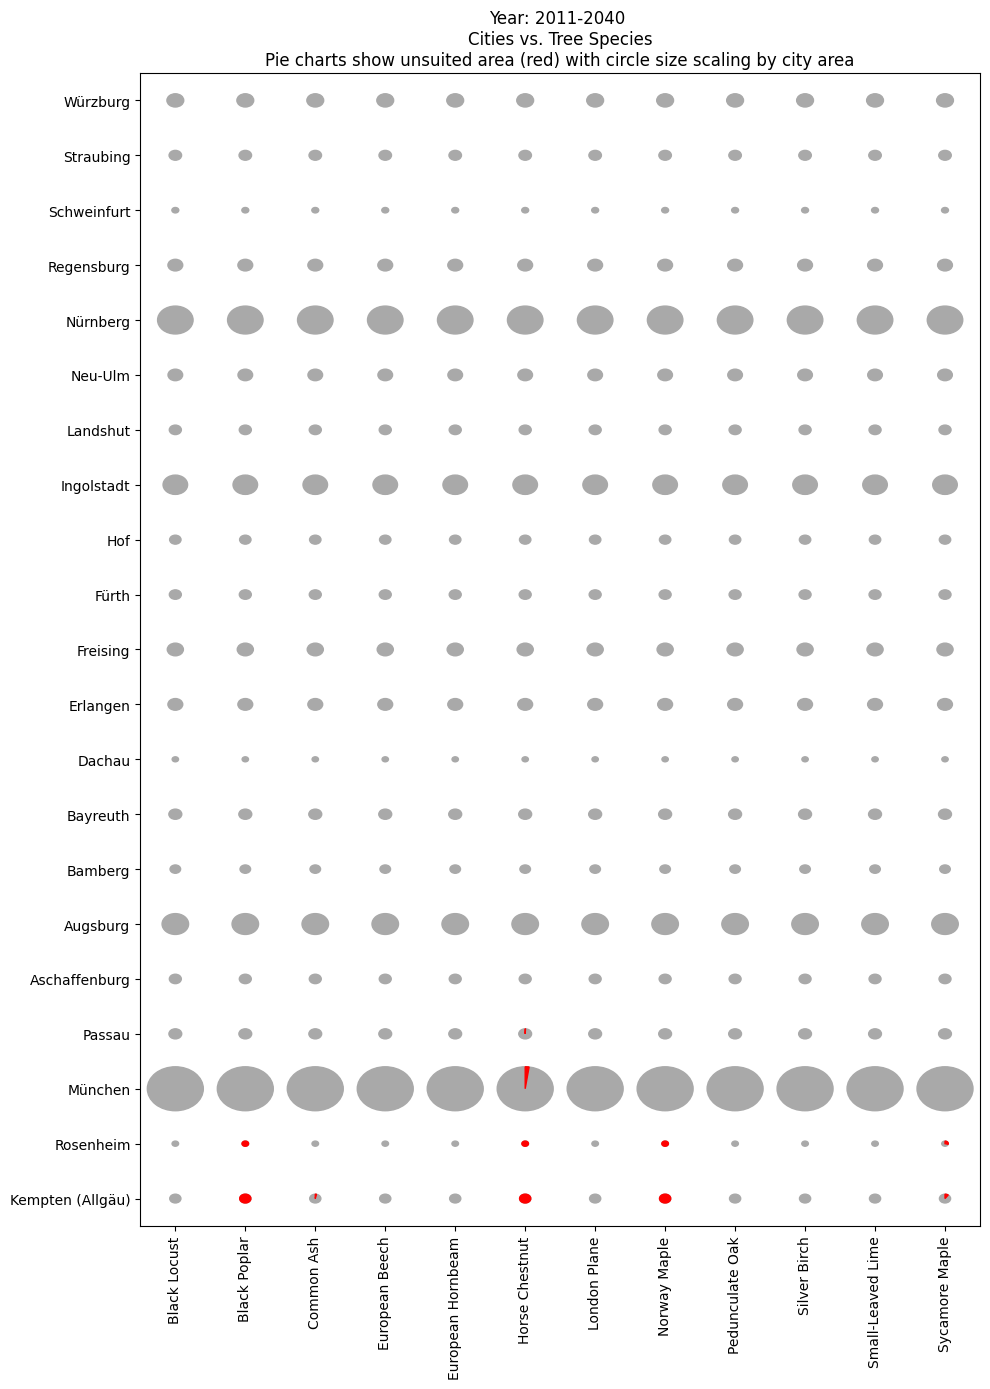

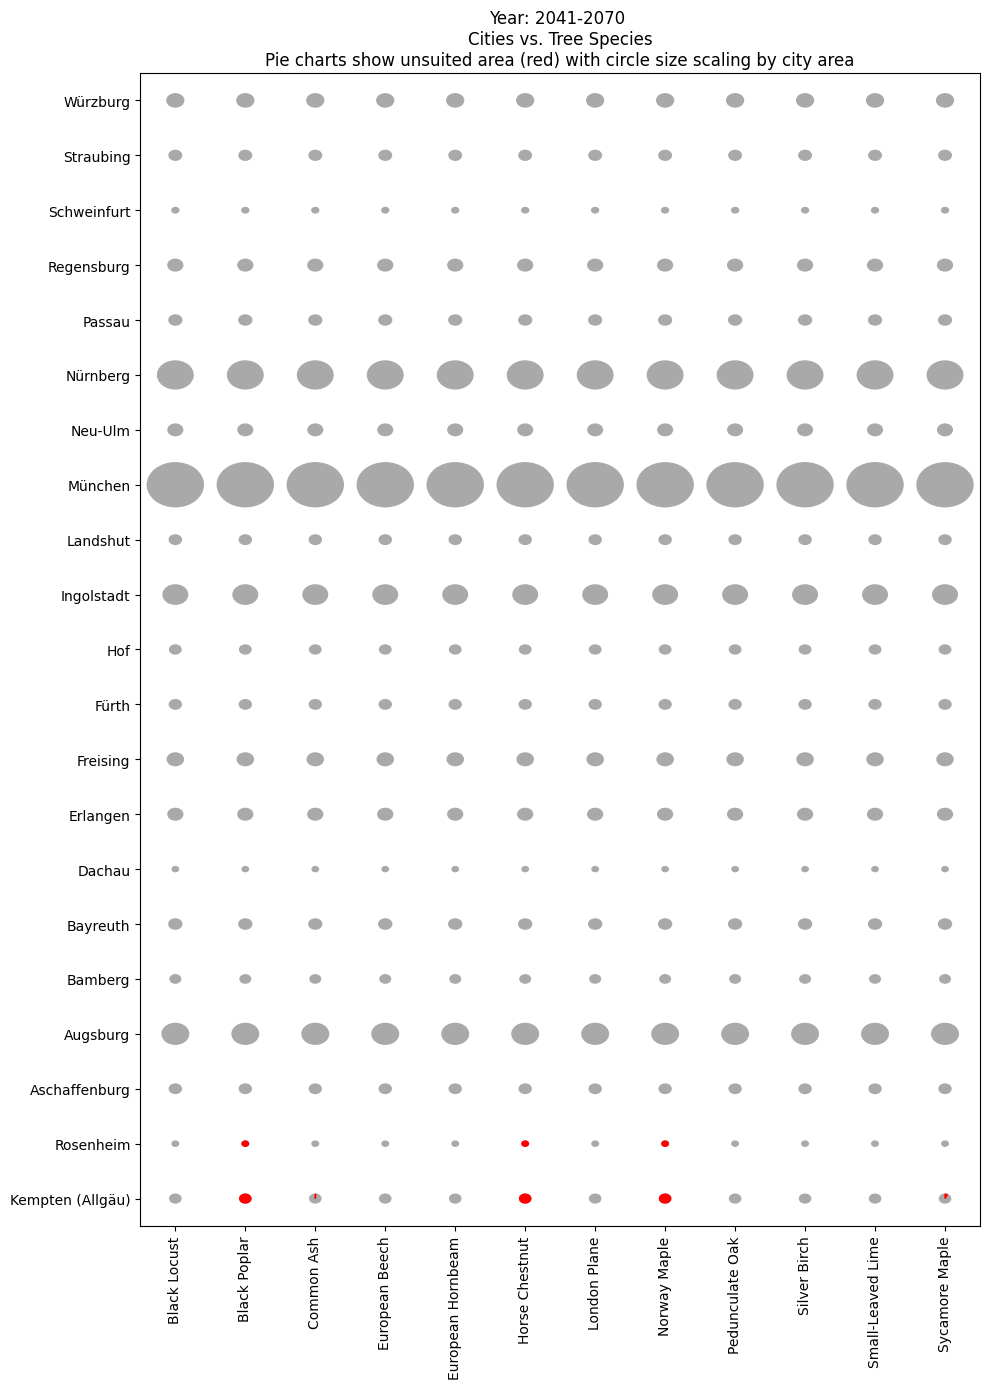

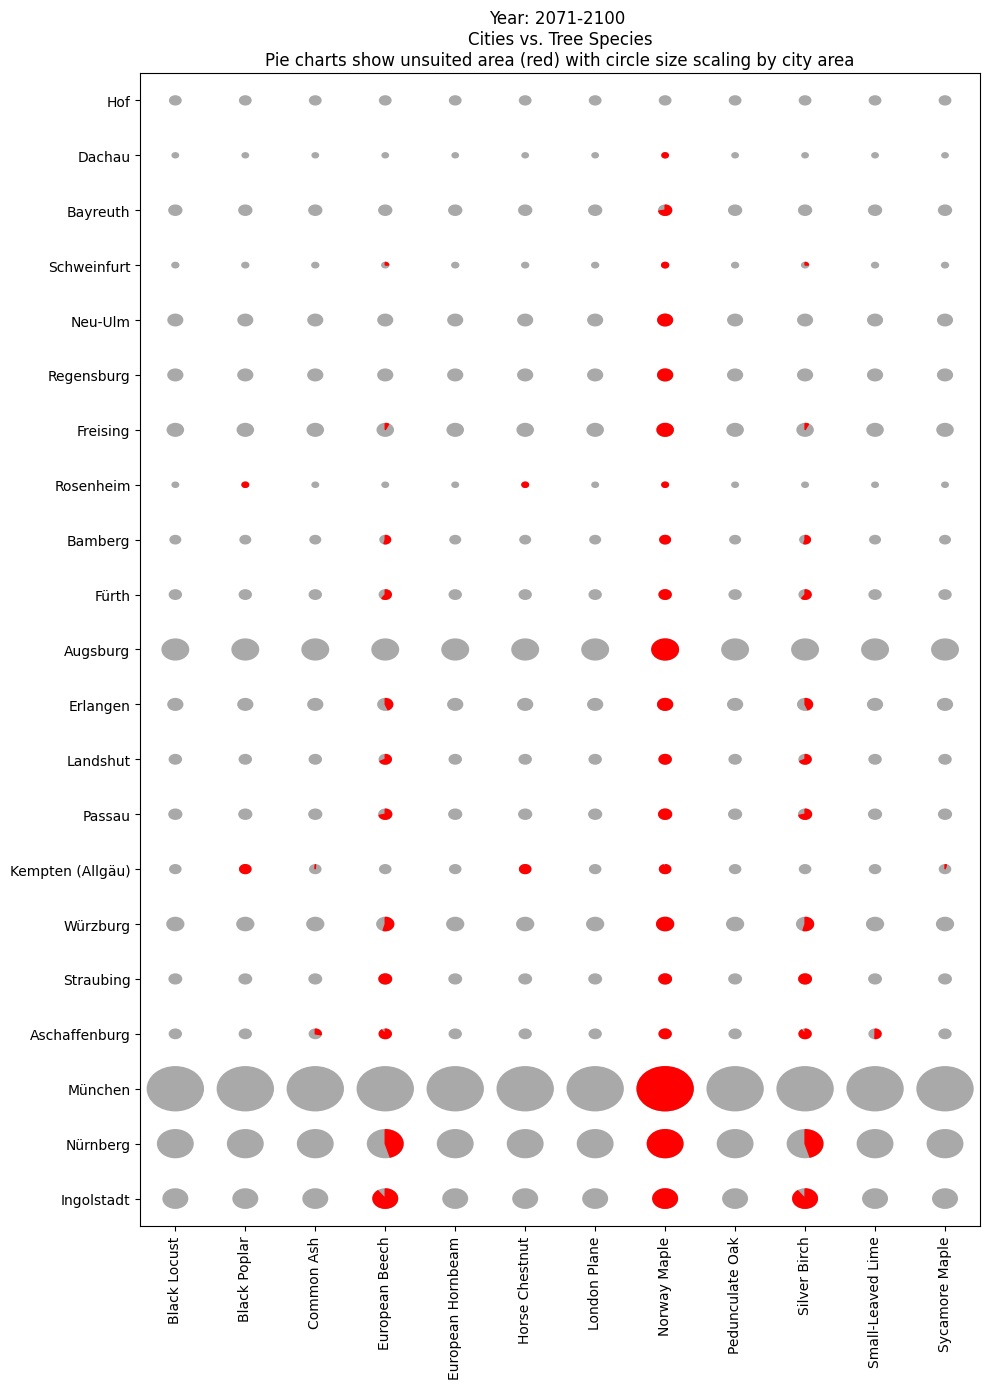

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle

# ---------------------------
# 0. Load and Preprocess the CSV Data
# ---------------------------
df_results = pd.read_csv('results.csv')

# Map species names from German to English
species_mapping = {
    "Rotbuche": "European Beech",
    "Spitzahorn": "Norway Maple",
    "Bergahorn": "Sycamore Maple",
    "Gemeine Robinie": "Black Locust",
    "Gewöhnliche Rosskastanie": "Horse Chestnut",
    "Haengebirke/Sandbirke": "Silver Birch",
    "Hainbuche": "European Hornbeam",
    "Londoner Platane": "London Plane",
    "Schwarzpappel": "Black Poplar",
    "Stieleiche": "Pedunculate Oak",
    "Winterlinde": "Small-Leaved Lime",
    "Gemeine Esche": "Common Ash"
    # Füge ggf. weitere Zuordnungen hinzu.
}
df_results["Species"] = df_results["Species"].replace(species_mapping)

# ---------------------------
# 1. Retrieve City Areas for Scaling the Circle Size
# ---------------------------
# Lade das Shapefile ("VG250_GEM.shp") und verarbeite die Stadtflächen.
gdf = gpd.read_file("VG250_GEM.shp")
gdf["ARS_0"] = gdf["ARS_0"].astype(str)

ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf["ARS_0"].isin(ars_list)].copy()

# Reprojiziere in ein metrisches Koordinatensystem (hier EPSG:3857) für Flächenberechnungen.
gdf_filtered_metric = gdf_filtered.to_crs(epsg=3857)
gdf_filtered_metric["area"] = gdf_filtered_metric["geometry"].area

# Annahme: Der Stadtname befindet sich in der Spalte "GEN".
city_area = dict(zip(gdf_filtered_metric["GEN"], gdf_filtered_metric["area"]))
max_area = max(city_area.values())
max_diam = 0.8  # Maximale Kreis-Durchmesser (in Plot-Einheiten)

# ---------------------------
# 2. Loop Over Each Time Step (Year) and Create a Plot
# ---------------------------
unique_years = sorted(df_results['Time_Frame'].unique())

for year in unique_years:
    # Filtere Daten für das aktuelle Zeitintervall
    df_year = df_results[df_results["Time_Frame"] == year].copy()

    # Für jede Kombination aus Stadt und Baumart: benutze den minimalen PCT_VALID-Wert in diesem Zeitintervall.
    df_min = df_year.groupby(["City", "Species"])["PCT_VALID"].min().reset_index()

    # Berechne den unsuitierten Anteil (als Prozentzahl der verlorenen Fläche) pro Zelle.
    df_min["Unsuitable"] = 100 - df_min["PCT_VALID"]

    # Erstelle eine Pivot-Tabelle (Zeilen = Städte, Spalten = Baumarten, Werte = Unsuitable)
    pivot_unsuitable = df_min.pivot(index="City", columns="Species", values="Unsuitable")

    # ---------------------------
    # 2a. Sortiere Städte basierend auf der aggregierten Verlustfläche
    # ---------------------------
    # Hier multiplizieren wir für jede vorhandene Zelle den unsuitierten Anteil
    # (als Bruch, also Unsuitable/100) mit der tatsächlichen Stadtfläche (city_area).
    # Anschließend summieren wir diese Flächen für jede Stadt.
    lost_areas = {}
    for city in pivot_unsuitable.index:
        # Ziehe nur die vorhandenen (nicht-NaN) Werte heran und wandle in Bruch um.
        f_values = pivot_unsuitable.loc[city].dropna() / 100.0
        # Die echte Stadtfläche laut Shapefile (gdf_filtered_metric["area"])
        area_val = city_area.get(city, 0)
        # Für jede Baumart: Verlust = (Unsuitable-Anteil) * Stadtfläche.
        # Hier wird über alle vorhandenen Baumarten aufsummiert.
        lost_area = (f_values * area_val).sum()
        lost_areas[city] = lost_area

    # Sortiere die Städte absteigend nach der berechneten Gesamtverlustfläche.
    sorted_cities = sorted(lost_areas, key=lambda x: lost_areas[x], reverse=True)
    pivot_unsuitable = pivot_unsuitable.loc[sorted_cities]
    cities = pivot_unsuitable.index.tolist()
    species = pivot_unsuitable.columns.tolist()

    # ---------------------------
    # 3. Erstelle den Scatter-Plot mit Kreis-Pie-Charts für das aktuelle Jahr
    # ---------------------------
    fig, ax = plt.subplots(figsize=(10, 14))

    for i, city in enumerate(cities):
        for j, sp in enumerate(species):
            # Überspringe Zellen ohne Daten.
            if pd.isna(pivot_unsuitable.loc[city, sp]):
                continue

            # Unsuited percentage (0 bis 100)
            unsuited = pivot_unsuitable.loc[city, sp]
            # Bruch unsuited (zwischen 0 und 1)
            f = unsuited / 100.0

            # Berechne den Plot-Kreis-Durchmesser basierend auf der Stadtfläche (linear skaliert)
            area_val = city_area.get(city, 0)
            diam = (area_val / max_area) * max_diam
            radius = diam / 2.0

            # Position: x = Index der Baumart, y = Index der Stadt.
            x = j
            y = i

            # Zeichne den Basis-Kreis (in dunkelgrau) als Grundlage.
            base_circle = Circle((x, y), radius=radius, color='darkgrey', zorder=1)
            ax.add_patch(base_circle)

            # Falls ein unsuitierter Anteil vorliegt, überlagere einen roten Wedge (Kuchenstück)
            if f > 0:
                # Der Wedge wird ab 90° (oben) im Uhrzeigersinn gezeichnet.
                wedge = Wedge((x, y), radius, theta1=90 - 360*f, theta2=90, color='red', zorder=2)
                ax.add_patch(wedge)

    # Setze Achsen-Limits, damit alle Zellen sichtbar sind.
    ax.set_xlim(-0.5, len(species) - 0.5)
    ax.set_ylim(-0.5, len(cities) - 0.5)

    # Setze Tick-Labels für Baumarten (x-Achse) und Städte (y-Achse)
    ax.set_xticks(np.arange(len(species)))
    ax.set_xticklabels(species, rotation=90)
    ax.set_yticks(np.arange(len(cities)))
    ax.set_yticklabels(cities)

    ax.set_title(f"Year: {year} \nCities vs. Tree Species\nPie charts show unsuited area (red) with circle size scaling by city area")
    plt.tight_layout()
    plt.show()



Analysis of Landcover Classes in the analysed Bavarian cities. Therefore, data from a Landuse-classification has to be downloaded (Krüger, T., Eichler, L., Meinel, G., Tenikl, J., Taubenböck, H., & Wurm, M. (2022). Urban Green Raster Germany 2018 (1 (2021)) [Data set]. Zenodo. https://doi.org/10.26084/ioerfdz-r10-urbgrn2018). Then the data is merged with the administrative boundaries of the cities.

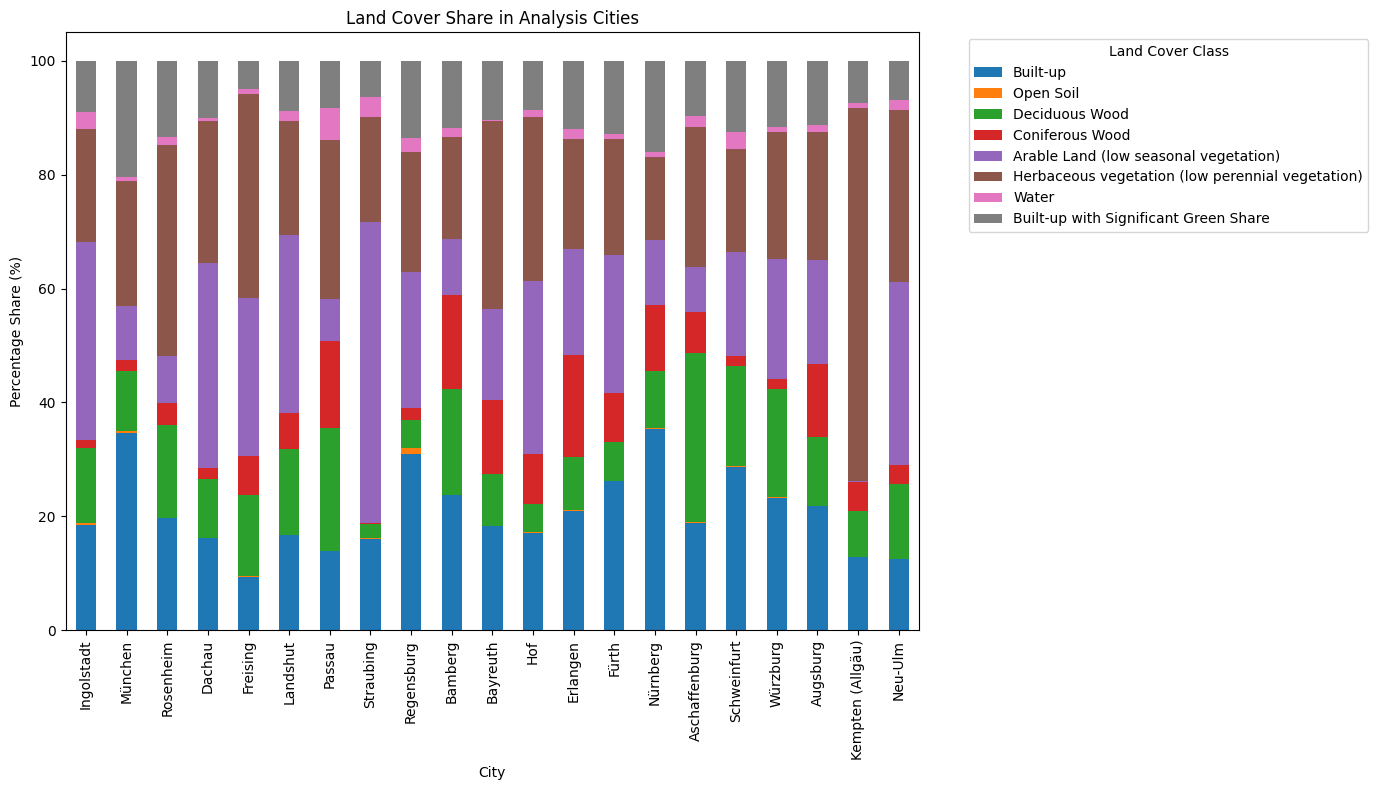

In [19]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# 1. Load and filter the shapefile
# ------------------------------
shapefile_path = "VG250_GEM.shp"
gdf = gpd.read_file(shapefile_path)

ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)].copy()

# ------------------------------
# 2. Land-cover raster setup
# ------------------------------
# Path to your land-cover GeoTIFF (with 8 classes)
landcover_path = "ugr2018_germany.tif"

# Land-cover classes mapping (1 to 8)
landcover_classes = {
    1: 'Built-up',
    2: 'Open Soil',
    3: 'Deciduous Wood',
    4: 'Coniferous Wood',
    5: 'Arable Land (low seasonal vegetation)',
    6: 'Herbaceous vegetation (low perennial vegetation)',
    7: 'Water',
    8: 'Built-up with Significant Green Share'
}

# Reproject the shapefile to the raster’s CRS if needed.
with rasterio.open(landcover_path) as src:
    landcover_crs = src.crs

if gdf_filtered.crs != landcover_crs:
    gdf_filtered = gdf_filtered.to_crs(landcover_crs)

# ------------------------------
# 3. Calculate land-cover share for each city
# ------------------------------
results_landcover = []

with rasterio.open(landcover_path) as src:
    for idx, row in gdf_filtered.iterrows():
        city = row["GEN"]
        polygon = row.geometry

        # Mask the raster using the city polygon
        out_image, out_transform = mask(src, [polygon.__geo_interface__],
                                        crop=True, all_touched=True, filled=True)
        data = out_image[0]  # assume a single band

        # Create a mask to select only pixels that fall within the polygon
        poly_mask = geometry_mask([polygon.__geo_interface__],
                                  out_shape=data.shape,
                                  transform=out_transform,
                                  invert=True)
        # Extract only the pixels within the polygon
        data_inside = data[poly_mask]
        total_pixels = data_inside.size

        if total_pixels == 0:
            continue

        # Count pixels for each land-cover class (ignoring any nodata or background if present)
        unique, counts = np.unique(data_inside, return_counts=True)
        counts_dict = dict(zip(unique, counts))

        # Calculate percentage share for each class
        shares = {}
        for cls in range(1, 9):
            count = counts_dict.get(cls, 0)
            share = count / total_pixels * 100
            shares[landcover_classes[cls]] = share

        shares['City'] = city
        results_landcover.append(shares)

# Convert results to a DataFrame
df_landcover = pd.DataFrame(results_landcover)
df_landcover = df_landcover.set_index('City')
#print(df_landcover)

df_landcover.to_csv('landcover_share.csv')
# ------------------------------
# 4. Plotting the land-cover shares
# ------------------------------
# Create a stacked bar chart where each bar (city) is split by land-cover classes.
ax = df_landcover.plot(kind='bar', stacked=True, figsize=(14, 8))

plt.ylabel('Percentage Share (%)')
plt.title('Land Cover Share in Analysis Cities')
plt.legend(title='Land Cover Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.stats as stats

# ---------------
# 1. Daten laden und vorbereiten
# ---------------
# Lade die Landcover Share Daten (exportiert aus deinem Landcover-Analyse-Code)
df_landcover = pd.read_csv('landcover_share.csv', index_col='City')

# Lade die Ergebnisse der Klima-Envelope-Analyse (results.csv)
df_results = pd.read_csv('results.csv')

# Berechne den unsuitability-Wert (100 - PCT_VALID) für jede Zeile
df_results['Unsuitable'] = 100 - df_results['PCT_VALID']

# Aggregiere den unsuitability-Wert pro Stadt
city_unsuitability = df_results.groupby('City')['Unsuitable'].mean()

# Kombiniere die Landcover-Daten mit dem aggregierten unsuitability-Wert.
# Dabei gehen wir davon aus, dass die Städtenamen in beiden Datensätzen übereinstimmen.
df_combined = df_landcover.copy()
df_combined['Avg_Unsuitable'] = city_unsuitability


# ---------------
# 6. Vergleichsanalyse
# ---------------
# Teile die Städte in zwei Gruppen ein: 'High Loss' (Avg_Unsuitable >= Median) und 'Low Loss' (unter Median)
median_unsuitability = df_combined['Avg_Unsuitable'].median()
df_combined['Group'] = np.where(df_combined['Avg_Unsuitable'] >= median_unsuitability, 'High Loss', 'Low Loss')

# Um die Landcover-Anteile zu vergleichen, schmelzen wir den DataFrame:
df_melt = df_landcover.reset_index().melt(id_vars='City', var_name='Landcover', value_name='Share')
# Füge die Gruppierung hinzu (über einen Merge)
df_melt = df_melt.merge(df_combined[['Avg_Unsuitable', 'Group']], left_on='City', right_index=True)

# Initialize an empty list to store results
results = []

# Loop over each unique landcover category
for lc in df_melt['Landcover'].unique():
    # Filter data for the current landcover and each group
    high_loss = df_melt[(df_melt['Landcover'] == lc) & (df_melt['Group'] == 'High Loss')]['Share']
    low_loss  = df_melt[(df_melt['Landcover'] == lc) & (df_melt['Group'] == 'Low Loss')]['Share']

    # Perform a t-test (Welch's t-test for unequal variances)
    t_stat, p_value = stats.ttest_ind(high_loss, low_loss, equal_var=False)

    # Append the results to our list
    results.append({'Landcover': lc, 't_stat': t_stat, 'p_value': p_value})

# Convert the results to a DataFrame for a nicer display
results_df = pd.DataFrame(results)
print(results_df)


                                          Landcover    t_stat   p_value
0                                          Built-up -0.181678  0.857967
1                                         Open Soil -1.246775  0.239661
2                                    Deciduous Wood  1.527755  0.147189
3                                   Coniferous Wood  0.011524  0.990929
4             Arable Land (low seasonal vegetation) -0.749640  0.464654
5  Herbaceous vegetation (low perennial vegetation)  0.140867  0.890022
6                                             Water  1.198197  0.247793
7             Built-up with Significant Green Share -0.361738  0.722314


Analysis of "high-loss" and "low-loss" group.

<ipython-input-25-0289f30d14ee>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels, rotation=0)  # Set labels horizontal


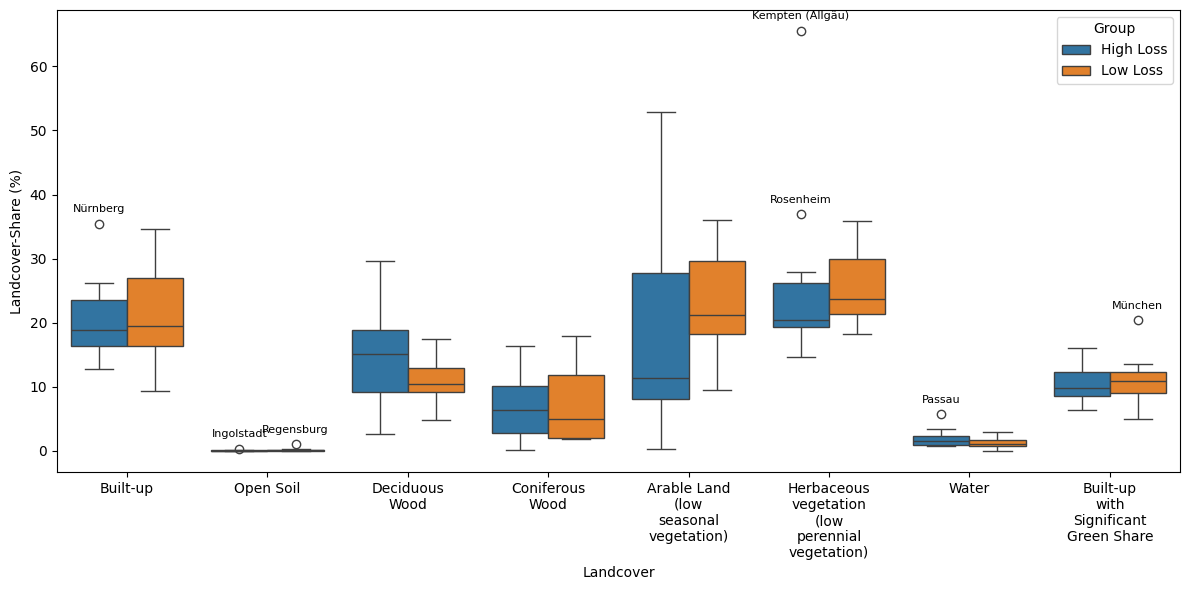

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import textwrap

# Assuming df_combined, df_landcover, and df_melt have been defined as in your code

# Group assignment based on the median of 'Avg_Unsuitable'
median_unsuitability = df_combined['Avg_Unsuitable'].median()
df_combined['Group'] = np.where(df_combined['Avg_Unsuitable'] >= median_unsuitability, 'High Loss', 'Low Loss')

# Melt the landcover DataFrame and merge with group information
df_melt = df_landcover.reset_index().melt(id_vars='City', var_name='Landcover', value_name='Share')
df_melt = df_melt.merge(df_combined[['Avg_Unsuitable', 'Group']], left_on='City', right_index=True)

# Define explicit order for consistency in plotting and annotation
landcover_order = list(df_melt['Landcover'].unique())
hue_order = ['High Loss', 'Low Loss']  # adjust this order as desired

# Create the boxplot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Landcover', y='Share', hue='Group', data=df_melt,
                 order=landcover_order, hue_order=hue_order)
#plt.title("Vergleich der Landcover-Anteile: High Loss vs. Low Loss Cities")
plt.ylabel("Landcover-Share (%)")

# Wrap long x-axis labels (e.g., if a label exceeds 10 characters, it will be split)
wrapped_labels = [textwrap.fill(label, width=12) for label in landcover_order]
ax.set_xticklabels(wrapped_labels, rotation=0)  # Set labels horizontal

# Offset for text annotation above the outlier points
text_offset = 1.8  # adjust as needed

# Annotate outliers with city names using the 1.5*IQR rule
# For each combination of Landcover and Group:
for landcover in landcover_order:
    for group in hue_order:
        subdata = df_melt[(df_melt['Landcover'] == landcover) & (df_melt['Group'] == group)]
        if subdata.empty:
            continue
        # Calculate quartiles and IQR
        q1 = subdata['Share'].quantile(0.25)
        q3 = subdata['Share'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Identify outliers
        outliers = subdata[(subdata['Share'] < lower_bound) | (subdata['Share'] > upper_bound)]

        # Determine the x-coordinate for annotation:
        # Seaborn’s boxplot with hue “dodges” the boxes.
        # With 2 groups and default box width ~0.8, we approximate offsets as -0.2 and +0.2.
        offset = -0.2 if group == hue_order[0] else 0.2
        x_coord = landcover_order.index(landcover) + offset

        # Annotate each outlier with its city name, placing text a little above the point
        for idx, row in outliers.iterrows():
            ax.text(x_coord, row['Share'] + text_offset, row['City'],
                    horizontalalignment='center', color='black', fontsize=8)

plt.tight_layout()
plt.show()



